# EarthXHack
## Leidy Buescher, Luiza Santos 
employment data:
https://fred.stlouisfed.org/series/TXMANRQGSP
https://www.dallasfed.org/research/economics/2020/0407
https://www.bls.gov/regions/west/ca_sandiego_msa.htm

In [12]:
# import libraries
import requests
import json
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

In [32]:
# Use beautiful soup to get the seriesid and name

city_urls = 'https://www.bls.gov/regions/west/ca_sandiego_msa.htm'
data_urls = {}
request = requests.get(city_urls)
soup = BeautifulSoup(request.text, 'html.parser')
i = 0
for link in soup.html.find_next('tbody').find_next('tbody').find_all('tr'):
    try:
        title = link.find_next('p').getText()
        url = link.find_next('a').find_next('a').get('href')
        data_urls[url] = title
    except:
        print('missing')
#print(data_urls)
# soup.html.find_next('tbody').find_next('tbody').find_next('tr').find_next('tr').find_next('p').getText()
# soup.html.find_next('tbody').find_next('tbody').find_next('tr').find_next('tr').find_next('a').find_next('a').get('href')

In [33]:
#contin'd last step 

http = re.compile(r'^https://data.bls.gov/timeseries/[a-zA-Z0-9]+')
code = re.compile(r'[a-zA-Z0-9]+')
new_dict = {}
for url,title in data_urls.items():
    try:
        complete_match = http.match(url).group()
        if complete_match:
            match = code.findall(complete_match)[-1]
            new_dict[match] = title
    except:
        pass
data_urls = new_dict
data_urls

{'LAUMT064174000000006': 'Civilian Labor Force(1)',
 'LAUMT064174000000005': 'Employment(1)',
 'LAUMT064174000000004': 'Unemployment(1)',
 'LAUMT064174000000003': 'Unemployment Rate(3)',
 'SMU06417400000000001': 'Total Nonfarm(4)',
 'SMU06417401000000001': 'Mining and Logging(4)',
 'SMU06417402000000001': 'Construction(4)',
 'SMU06417403000000001': 'Manufacturing(4)',
 'SMU06417404000000001': 'Trade, Transportation, and Utilities(4)',
 'SMU06417405000000001': 'Information(4)',
 'SMU06417405500000001': 'Financial Activities(4)',
 'SMU06417406000000001': 'Professional and Business Services(4)',
 'SMU06417406500000001': 'Education and Health Services(4)',
 'SMU06417407000000001': 'Leisure and Hospitality(4)',
 'SMU06417408000000001': 'Other Services(4)',
 'SMU06417409000000001': 'Government(4)',
 'CUURS49ESA0': 'CPI-U, All items(5)',
 'CWURS49ESA0': 'CPI-W, All items(6)'}

In [35]:
# import data

headers = {'Content-type': 'application/json'}
data = json.dumps({"seriesid": [*data_urls.keys()],"startyear":"2015", "endyear":"2020"})
p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
json_data = json.loads(p.text)

In [132]:
# change the data to dataframe 

df = pd.DataFrame()
for serie in json_data['Results']['series']:
    data = serie['data']
    for item in data:
        item['series'] = data_urls[serie['seriesID']]
        if 'footnotes' in item.keys():
            item.pop('footnotes')
        if 'latest' in item.keys():
            item.pop('latest')
    df = df.append(data, ignore_index = True)

In [133]:
# change the column formats
# df.dtypes
dates = [df.year[i] + df.period[i] for i in range(len(df))]
datetimes = pd.to_datetime(times,format='%YM%m' )
df.year = datetimes
df = df.drop(['period','periodName'],axis=1)

In [134]:
df.value = pd.to_numeric(df.value)
df.series = df.series.astype('category')
df.dtypes

year      datetime64[ns]
value            float64
series            object
dtype: object

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.


(-1.1002726355835122,
 1.1000130169571622,
 -1.108311324191775,
 1.109649356336821)

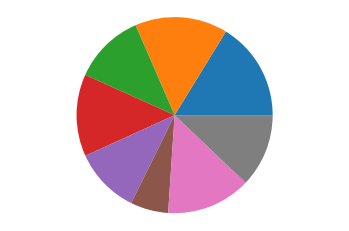

In [162]:
# plot data
%matplotlib inline

# example
# df[df.series.astype('str').str.startswith('Government')].value.describe()
# df[df.series.astype('str').str.startswith('Government')].value.plot.density()

# plot all
# cat = df.series.unique()
# for i in cat:
#     df[df.series.astype('str').str.startswith(i)].value.describe()
#     df[df.series.astype('str').str.startswith(i)].value.plot.density()

## every one seems to have at least two distributions it could be generated by some change in time
# two_years = df[df.year >= '2019-01-01']
# current_series = two_years
# for i in cat:
#     current_series[current_series.series.astype('str').str.startswith(i)].value.describe()
#     current_series[current_series.series.astype('str').str.startswith(i)].value.plot.density()
#     plt.show()

## it still seems to have two distributions, it is generated by something else
# industries = two_years[(two_years.value > 100) & (two_years.value <1000)]

# averages = industries.groupby('series').mean()
# fig1, ax1 = plt.subplots()
# ax1.pie(averages)
# ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

#sns.lineplot(x= 'year', y= 'value',hue='series',data=industries)